In [1]:
# imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import os
import math
import random
import timeit

In [2]:
# 1.2 plot

def plot_lines(img, lines):
    res = img.copy()
    if lines is None:
        return res
    for i in range(len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = rho * a
        y0 = rho * b
        pt1 = (int(x0 + 10000 * (-b)), int(y0 + 10000 * (a)))
        pt2 = (int(x0 - 10000 * (-b)), int(y0 - 10000 * (a)))
        cv.line(res, pt1, pt2, (0, 0, 255), 3, cv.LINE_AA)
    return res


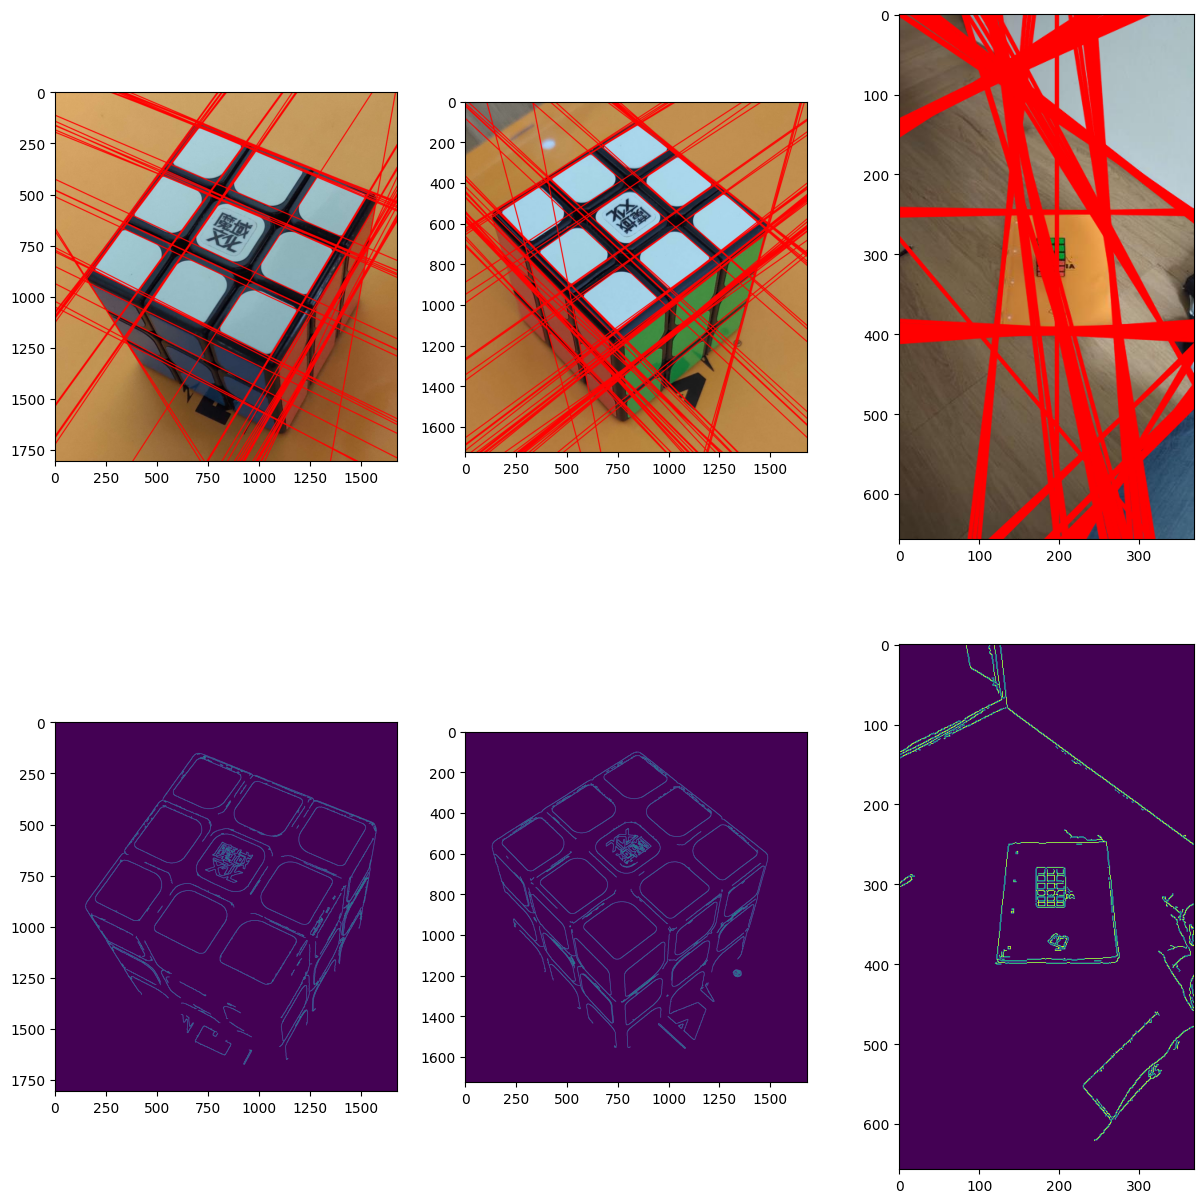

In [3]:
im1 = cv.imread('data/rubik1.jpg')
im2 = cv.imread('data/rubik2.jpg')
im3 = cv.imread('data/rubik5.jpg')

# 1.1 Hougs transform

canny_edge_1 = cv.Canny(im1, 50, 200, None, 3)
canny_edge_2 = cv.Canny(im2, 50, 200, None, 3)
canny_edge_3 = cv.Canny(im3, 50, 200, None, 3)

im1l = cv.HoughLines(canny_edge_1, 1, np.pi / 180.0, 150)
im2l = cv.HoughLines(canny_edge_2, 1, np.pi / 180.0, 150)
im3l = cv.HoughLines(canny_edge_3, 1, np.pi / 180.0, 50)

im1l = plot_lines(im1, im1l)
im2l = plot_lines(im2, im2l)
im3l = plot_lines(im3, im3l)


im1l = cv.cvtColor(im1l, cv.COLOR_BGR2RGB)
im2l = cv.cvtColor(im2l, cv.COLOR_BGR2RGB)
im3l = cv.cvtColor(im3l, cv.COLOR_BGR2RGB)

row = 2
col = 3
i = 1
plt.figure(figsize=(15, 15))
plt.subplot(row, col, i), plt.imshow(im1l)
i+=1
plt.subplot(row, col, i), plt.imshow(im2l)
i+=1
plt.subplot(row, col, i), plt.imshow(im3l)
i+=1
plt.subplot(row, col, i), plt.imshow(canny_edge_1)
i+=1
plt.subplot(row, col, i), plt.imshow(canny_edge_2)
i+=1
plt.subplot(row, col, i), plt.imshow(canny_edge_3)
i+=1
plt.show()

# A. Computing vanishing points: questions

## 1. The number of vanishing points

Between 0 and 3 finite vanishing points can be found from all possible images of a Rubik's cube. This is because our 3D world, once projected onto a 2D photography only has 3 degrees of freedom for the viewpoint: Left and right, up and down, forward and backward.

For the minimum, the least you can have is 0
- When you take a really zoomed in picture (inside a green square for exemple with no edge visible) because there will be no parallel lines. 
- When you take a perfect picture of a single face like a 2D square, because the lines on the Rubik's Cube will be parallel and will have the same depth (to the camera), the lines projected onto the image in 2D will be perfectly parallel and will never intersect to give vanishing points.

But for a more realistic picture where you can see only one whole face, there will be probably a rotation so, even if it will be a 2d square with only x and y axis, thoses axis parallel lines will converge to a single point for at least one axis event if it is really far, giving 1 vanishing points.





## 2 TODO.
Yes, there will be one vanishing point per axis

## 3. 

No, we will never be able to find a 4th vanishing point because the photo takes a 3D image (our world) onto a 2D image, so there are only 3 axes to be deformed by the perspective which means that we will only be able to fid 3 vanishing points at most. That's only 

If you change perspective to deform parallels (like a fish eye camera) you may be able to find more than 3 vanishing points, because line will become curved and will be able to intersect more than 3 times. this is not possible with a normal camera, but specialized fish eye cameras can do that and you will be able to find <a href="https://ieeexplore.ieee.org/document/5190078">4 vanishing points.</a>

## 4.

Vanishing points can be outside of the image. Take the following picture for example:

<img src="data/rubik4.jpg" width="200"></img>

In [4]:
# part B : Computing fundamental matrix

# functions to get the matching points from the user
def get_points_from_user(image):
    # Function to handle mouse clicks
    def click_event(event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            points.append((x, y))
            cv.circle(param['image'], (x, y), 5, (0, 255, 0), -1)
            cv.imshow(param['window_name'], param['image'])

    # Display image
    cv.imshow('Image', image)

    # Initialize array to store points
    points = []

    # Set the mouse callback function
    cv.setMouseCallback('Image', click_event, {'image': image, 'window_name': 'Image'})

    # Wait until the user clicks on the image
    while True:
        key = cv.waitKey(1)
        if key == 13 or key == 27:  # Break if 'Enter' is pressed
            break

    # Convert points to NumPy array
    points_array = np.array(points)

    # Display the clicked points
    print("Clicked Points:", points_array)

    return points_array

def get_matching_points_from_user(image1, image2):
    print("provide points on the first image : \n")
    clicked_points_image1 = get_points_from_user(image1)
    print("provide corresponding points on the second image : \n")
    clicked_points_image2 = get_points_from_user(image2)
    cv.destroyAllWindows()
    return clicked_points_image1, clicked_points_image2

   




In [5]:
# get points from user using the above functions
image_left = cv.imread('data/rubik10.jpg')
image_right = cv.imread('data/rubik11.jpg')


# Check if images are loaded successfully
if image_left is None or image_right is None:
    print("Error: Could not load images.")
    exit()
    
points_left, points_right = get_matching_points_from_user(image_left, image_right)

# match the points together
def create_matching_points(array1, array2):
    matching_points = list(zip(array1, array2))
    return matching_points

# Create matching points
matching_points = create_matching_points(points_left, points_right)

provide points on the first image : 

Clicked Points: [[214 211]
 [292 245]
 [252 296]
 [167 257]
 [279 316]
 [237 362]
 [163 323]]
provide corresponding points on the second image : 

Clicked Points: [[247 177]
 [309 223]
 [222 266]
 [164 209]
 [300 304]
 [218 342]
 [171 288]]


In [6]:
def display_matched_points(image1, image2, matching_points):
    # Concatenate the two images horizontally
    result_image = np.hstack((image1, image2.copy()))

    # Convert points to integer
    matching_points = np.int32(matching_points)

    # Draw lines connecting matched points
    for point1, point2 in matching_points:
        point2[0] += image1.shape[1]  # Adjust x-coordinate for the second image
        cv.line(result_image, tuple(point1), tuple(point2), (0, 255, 0), 2)

    # Display the result image
    cv.imshow('Matched Points', result_image)
    cv.waitKey(0)
    cv.destroyAllWindows()
    

# Display the matched points
display_matched_points(image_left, image_right, matching_points)

In [7]:
# writing an epipolar constraint for each pair of points
# and rearranging it into a matrix such that Af = 0 (forming a linear system)

def construct_A_matrix_row(point1, point2): #points of shape (x, y, 1) = to their coordinates in their image.
    x1, y1, _ = point1
    x2, y2, _ = point2

    A = np.array([
        x1 * x2, x1 * y2, x1,
        y1 * x2, y1 * y2, y1,
        x2, y2, 1
    ])

    return A

# appending a 1 to each of the points previously detected (using homogeneous coordinates)
points_left = np.hstack((points_left, np.ones((points_left.shape[0], 1))))
points_right = np.hstack((points_right, np.ones((points_right.shape[0], 1))))
 
print(points_left)
print('\n')
print(points_right)
print('\n')

A_matrix_list = [construct_A_matrix_row(point1, point2) for point1, point2 in zip(points_left, points_right)]
A_final = np.vstack(A_matrix_list)
print("A_total:", A_final)


[[214. 211.   1.]
 [292. 245.   1.]
 [252. 296.   1.]
 [167. 257.   1.]
 [279. 316.   1.]
 [237. 362.   1.]
 [163. 323.   1.]]


[[247. 177.   1.]
 [309. 223.   1.]
 [222. 266.   1.]
 [164. 209.   1.]
 [300. 304.   1.]
 [218. 342.   1.]
 [171. 288.   1.]]


A_total: [[5.28580e+04 3.78780e+04 2.14000e+02 5.21170e+04 3.73470e+04 2.11000e+02
  2.47000e+02 1.77000e+02 1.00000e+00]
 [9.02280e+04 6.51160e+04 2.92000e+02 7.57050e+04 5.46350e+04 2.45000e+02
  3.09000e+02 2.23000e+02 1.00000e+00]
 [5.59440e+04 6.70320e+04 2.52000e+02 6.57120e+04 7.87360e+04 2.96000e+02
  2.22000e+02 2.66000e+02 1.00000e+00]
 [2.73880e+04 3.49030e+04 1.67000e+02 4.21480e+04 5.37130e+04 2.57000e+02
  1.64000e+02 2.09000e+02 1.00000e+00]
 [8.37000e+04 8.48160e+04 2.79000e+02 9.48000e+04 9.60640e+04 3.16000e+02
  3.00000e+02 3.04000e+02 1.00000e+00]
 [5.16660e+04 8.10540e+04 2.37000e+02 7.89160e+04 1.23804e+05 3.62000e+02
  2.18000e+02 3.42000e+02 1.00000e+00]
 [2.78730e+04 4.69440e+04 1.63000e+02 5.52330e+04 9.302

In [8]:
# computing the fundamental matrix using svd

_, _, V = np.linalg.svd(A_final)

# Extract the smallest singular value
f_vector = V[-1, :]
f_matrix = f_vector.reshape(3, 3)

# rank-2 constraint ensure the matrix is valid
# Ensure rank-2 constraint by performing SVD on f_matrix
U_f, D_f, Vt_f = np.linalg.svd(f_matrix)
D_f[-1] = 0  # Set the smallest singular value to 0 to enforce rank-2 constraint
f_matrix_rank2 = U_f @ np.diag(D_f) @ Vt_f

print("Fundamental Matrix (Rank-2):\n", f_matrix_rank2)


Fundamental Matrix (Rank-2):
 [[ 2.96458678e-06 -1.26571305e-05  2.90456555e-03]
 [ 1.30288698e-05  4.31969225e-06 -7.92766274e-03]
 [-5.38430502e-03  4.80899292e-03  9.99938297e-01]]


In [9]:
# check correctness using the epipolar constraints
for point1, point2 in zip(points_left, points_right):
    epipolar_constraint = point2 @ f_matrix_rank2 @ point1
    print("Epipolar Constraint:", epipolar_constraint)

# the closest the values to 0 = the best estimated matrix

Epipolar Constraint: 0.3285114508167023
Epipolar Constraint: 0.12924140681919144
Epipolar Constraint: 0.1502025752236934
Epipolar Constraint: 0.39062941688585484
Epipolar Constraint: 0.04698263398605984
Epipolar Constraint: 0.131803502507035
Epipolar Constraint: 0.2861180877187445


In [ ]:
# Choose corresponding points in the first image (you need to define these points)
points = np.hstack((points_left, points_right))

points = points.reshape(-1, 1, 3)

# Compute epipolar lines in the second image
lines2 = cv.computeCorrespondEpilines(points, 1, f_matrix_rank2)

# Draw the epipolar lines on the second image
image_right_with_lines = image_right.copy()
for line in lines2:
    a, b, c = line[0]
    x0, y0, x1, y1 = map(int, [0, -c/b, image_right.shape[1], -(c+a*image_right.shape[1])/b])
    cv.line(image_right_with_lines, (x0, y0), (x1, y1), (0, 255, 0), 1)

# Display the images
cv.imshow('Image left', image_left)
cv.imshow('Image right with Epipolar Lines', image_right_with_lines)
cv.waitKey(0)
cv.destroyAllWindows()

In [ ]:
# précision par inspection visuelle : ??
# plus c au centre plus c précis ? 

In [ ]:
# recomputing with normalized data 